# Unit Quality Control Reports 

In [1]:
# Imports
from convnwb.io import load_nwbfile, make_session_name

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('talk')

from convnwb.io import load_nwbfile
from convnwb.io import get_files, save_json

from spiketools.utils.timestamps import convert_sec_to_min, sum_time_ranges
from spiketools.plts.data import plot_bar, plot_hist, plot_text, plot_barh,plot_lines
from spiketools.plts.utils import make_grid, get_grid_subplot
from spiketools.spatial.utils import compute_pos_ranges, compute_bin_width
from spiketools.measures.trials import compute_segment_frs
from spiketools.measures.spikes import compute_firing_rate
from spiketools.plts.spatial import plot_position_by_time,plot_heatmap,create_heatmap_title
from spiketools.utils.extract import get_range
from spiketools.utils.epoch import epoch_spikes_by_range, epoch_spikes_by_event
from spiketools.plts.utils import save_figure
from spiketools.plts.data import plot_barh
from spiketools.plts.trials import plot_rasters
from spiketools.plts.annotate import add_vlines,add_box_shades
from spiketools.utils.extract import (get_range, get_values_by_time_range,
                                      get_values_by_times, threshold_spikes_by_values)
from spiketools.spatial.occupancy import compute_occupancy,compute_trial_occupancy, compute_bin_edges,compute_bin_counts_pos, normalize_bin_counts
from spiketools.utils.extract import get_range, get_values_by_time_range, get_values_by_times,get_inds_by_times

In [3]:
import sys
sys.path.append('../code')
from plts import plot_spikes_trial,plot_task_structure,plot_positions_with_speed
from utils import group_array_by_key,select_movement
from reports import create_sess_str
from trial import get_trial_structure
from group import get_all_session_paths

# Settings 

In [4]:
base_path = "/Users/weijiazhang/Data/Train/nwb"

In [5]:
session = {
    'experiment' : 'TRAIN',
    'subject' : 'UT088',
    'session' : '0'    
}

# Set which example unit to extract
uind = 3

In [6]:
experiment = session['experiment']
subject = session['subject']
sess = session['session']
session_name = make_session_name(subject,experiment,sess)
session_name

'TRAIN_UT088_session_0'

In [7]:
# Get the list of NWB files
nwbfiles = get_files(base_path)
nwbfiles

['TRAIN_EU001_session_0.nwb',
 'TRAIN_R1027J_session_0.nwb',
 'TRAIN_R1027J_session_1.nwb',
 'TRAIN_R1030J_session_0.nwb',
 'TRAIN_R1030J_session_1.nwb',
 'TRAIN_R1030J_session_2.nwb',
 'TRAIN_R1139C_session_0.nwb',
 'TRAIN_R1139C_session_1.nwb',
 'TRAIN_R1152C_session_0.nwb',
 'TRAIN_R1182C_session_0.nwb',
 'TRAIN_R1219C_session_0.nwb',
 'TRAIN_R1241J_session_0.nwb',
 'TRAIN_R1268T_session_0.nwb',
 'TRAIN_R1278E_session_0.nwb',
 'TRAIN_R1278E_session_1.nwb',
 'TRAIN_R1278E_session_3.nwb',
 'TRAIN_R1297T_session_0.nwb',
 'TRAIN_R1299T_session_0.nwb',
 'TRAIN_R1315T_session_0.nwb',
 'TRAIN_R1315T_session_1.nwb',
 'TRAIN_R1354E_session_0.nwb',
 'TRAIN_R1354E_session_1.nwb',
 'TRAIN_R1362E_session_0.nwb',
 'TRAIN_R1362E_session_1.nwb',
 'TRAIN_R1414E_session_1.nwb',
 'TRAIN_UT088_session_0.nwb',
 'zFailed']

# Load Data 

In [8]:
# Load NWB file
nwbfile = load_nwbfile(session, base_path)

/Users/weijiazhang/anaconda3/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/Users/weijiazhang/anaconda3/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.5.0 because version 2.6.0-alpha is already loaded.
  return func(args[0], **pargs)
/Users/weijiazhang/anaconda3/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)
/Users/weijiazhang/anaconda3/lib/python3.11/site-packages/pynwb/base.py:195: UserWarning: Timeseries has a rate of 0.0 Hz, but the length of the data is greater than 1.
  warn('Timeseries has a rate of 0.0 Hz, but the length of the data is greater than 1.')


In [9]:
# Get the number of trials 
n_trials = len(nwbfile.trials)
print('Number of trials: {}'.format(n_trials))
session['n_trials'] = n_trials

Number of trials: 64


In [10]:
# Check task time range 
task_range = [nwbfile.trials.start_time[0], nwbfile.trials.stop_time[-1]]

# Compute the task length, in minutes
task_len = convert_sec_to_min(task_range[1])

# Check the task / recording length, based on unit time
print('Task length: {:1.2f} minutes'.format(task_len))
session['task_length'] = np.round(task_len,2)

Task length: 45.56 minutes


In [11]:
nwbfile.trials

,start_time,stop_time,countdown_start_time,countdown_stop_time,cue_start_time,cue_stop_time,drive_type,feedback_start_time,feedback_stop_time,fixation_start_time,fixation_stop_time,movement_start_time,movement_stop_time,object,object_position,response_error,response_position,response_time,trial_type
id,,,,,,,,,,,,,,,,,,,
0,0.000000,29.807546,4.535931,8.638868,0.000000,4.535931,automatic,24.456627,29.807546,19.456627,24.456627,8.638868,19.456627,barrel,19.2954,0.7470,20.0424,17.582732,first
1,29.807546,73.927874,32.016512,36.038451,29.807546,32.016512,automatic,61.719060,73.927874,56.719060,61.719060,36.038451,56.719060,barrel,19.2954,1.8851,17.4103,53.491185,repeat
2,73.927874,109.466332,81.567757,85.637695,73.927874,81.567757,automatic,106.044385,109.466332,101.044385,106.044385,85.637695,101.044385,barrel,19.2954,1.9448,17.3506,95.402547,repeat
3,109.466332,136.200925,110.756313,114.837251,109.466332,110.756313,automatic,128.981035,136.200925,123.981035,128.981035,114.837251,123.981035,barrel,19.2954,2.0031,17.2923,121.364151,repeat


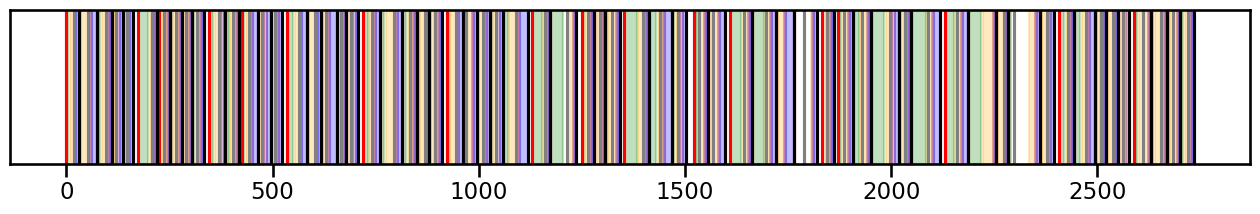

In [12]:
# Plot the task structure for the whole recording 
plot_task_structure(nwbfile.trials)

In [13]:
# Get the trail information
start_time = nwbfile.trials.start_time[:]
stop_time = nwbfile.trials.stop_time[:]
cue_starts = nwbfile.trials.cue_start_time[:]
cue_stops = nwbfile.trials.cue_stop_time[:]
move_start= nwbfile.trials.movement_start_time[:]
move_end= nwbfile.trials.movement_stop_time[:]
fixation_start= nwbfile.trials.fixation_start_time[:]
fixation_end= nwbfile.trials.fixation_stop_time[:]
feedback_start= nwbfile.trials.feedback_start_time[:]
feedback_end= nwbfile.trials.feedback_stop_time[:]
response_time= nwbfile.trials.response_time[:]

In [14]:
# Grab the position data
pos = nwbfile.acquisition['position']['player_position']
ptimes = pos.timestamps[:]
positions = pos.data[:]

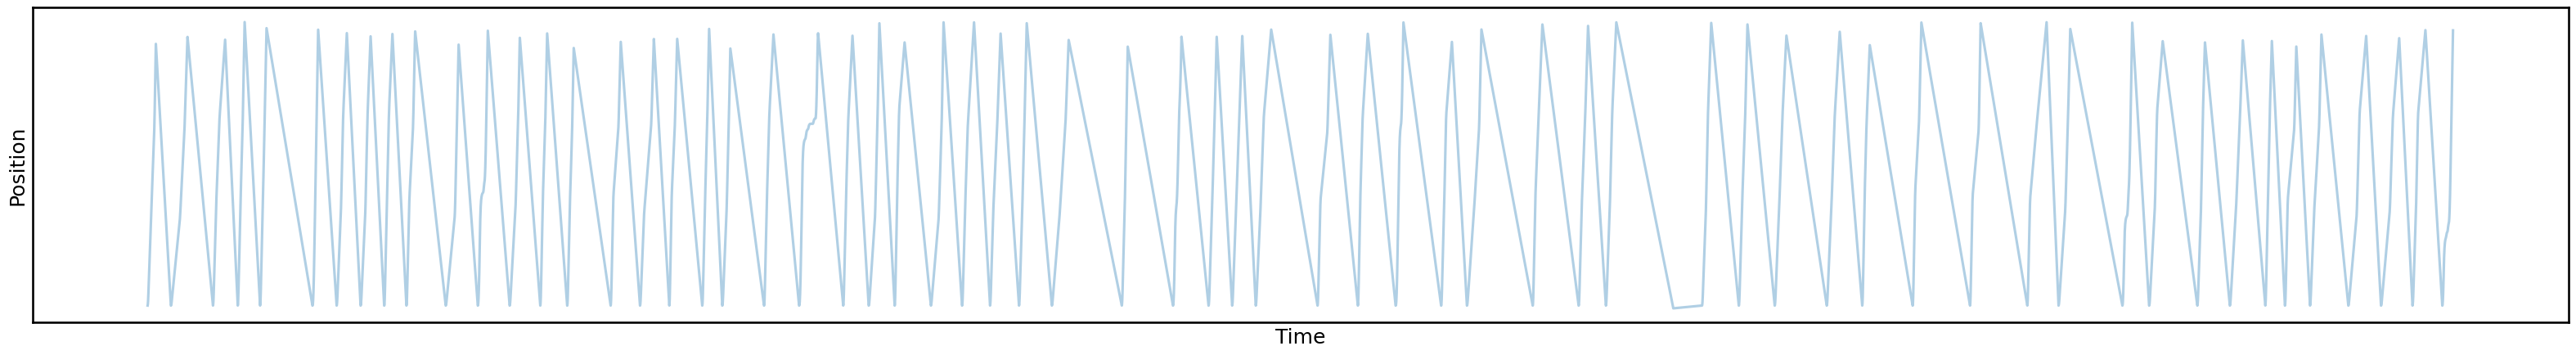

In [15]:
# Plot position across time
plot_position_by_time(pos.timestamps[:], pos.data[:], figsize=(40, 5))

In [16]:
# Get the trial structure based on positions
trial_start,trial_end = get_trial_structure(ptimes, positions,mini=-25,maxi = 25, dist = 100)

In [17]:
len(trial_start)

63

Text(0, 0.5, 'Position')

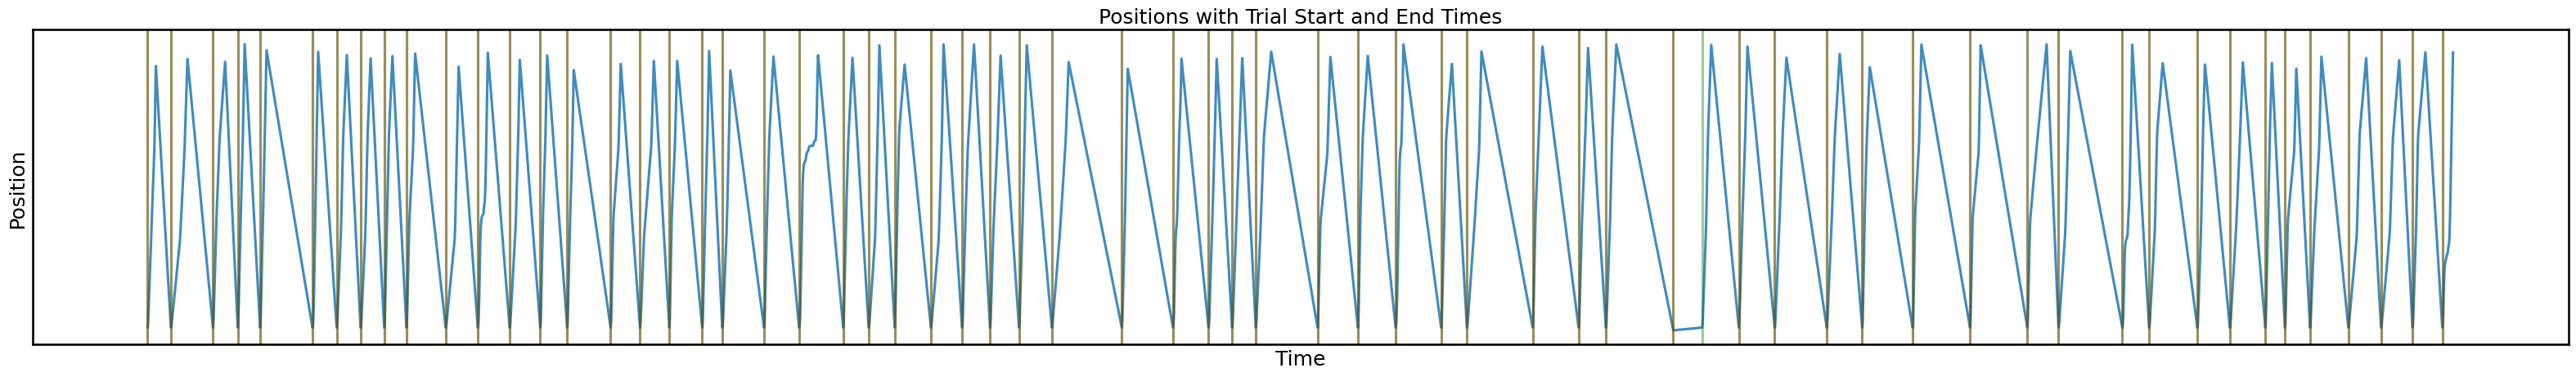

In [18]:
plot_position_by_time(ptimes, positions, alpha=0.85,figsize=(40, 5))
for start in trial_start:
    plt.axvline(x=start, color='red', alpha=0.4)
for end in move_start:
    plt.axvline(x=end, color='green', alpha=0.4)
plt.title('Positions with Trial Start and End Times')
plt.xlabel('Time')
plt.ylabel('Position')

Text(0, 0.5, 'Position')

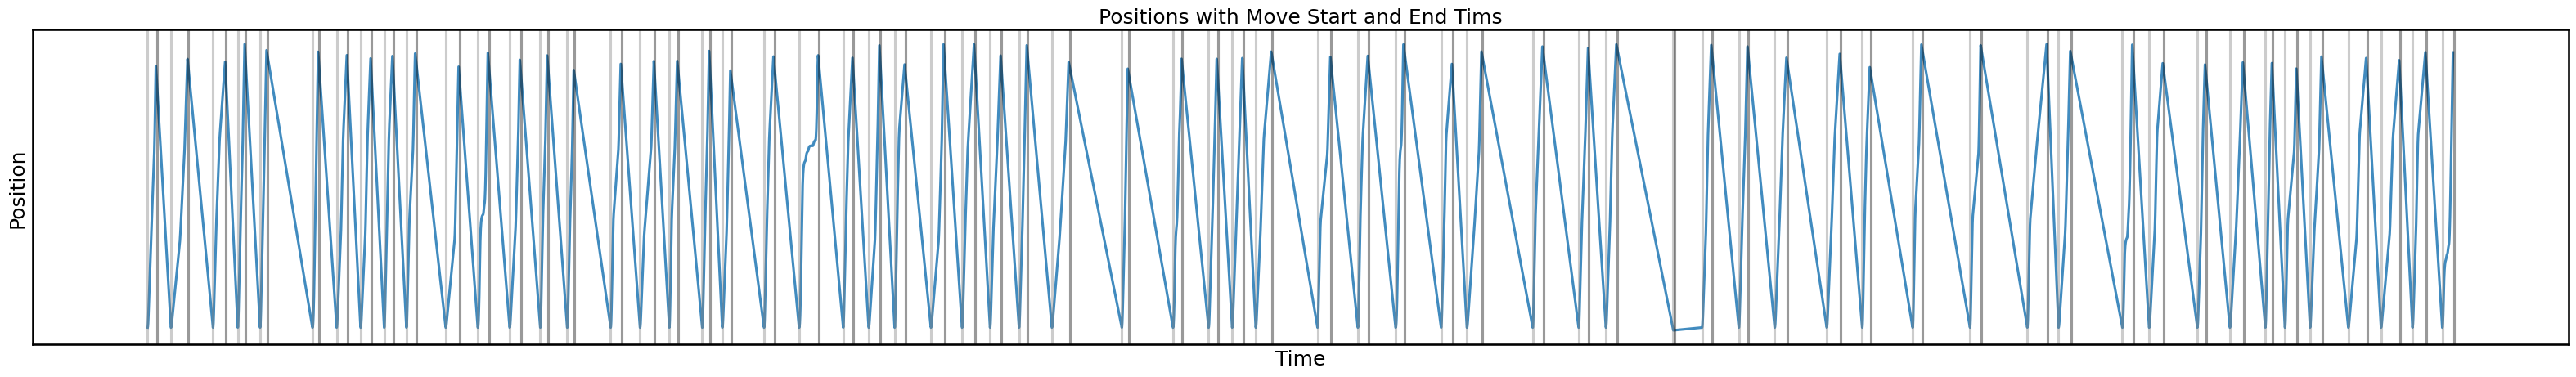

In [19]:
plot_position_by_time(ptimes, positions, alpha=0.85,figsize=(40, 5))

for start in move_start:
    plt.axvline(x=start, color='grey', alpha=0.4)
for end in move_end:
    plt.axvline(x=end, color='black', alpha=0.4)
plt.title('Positions with Move Start and End Tims')
plt.xlabel('Time')
plt.ylabel('Position')

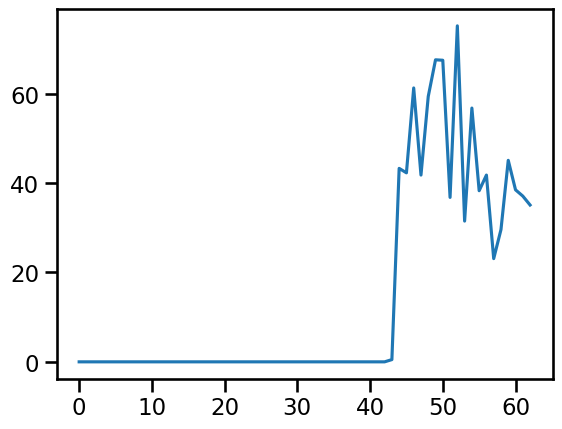

In [20]:
# Plot the difference between movement start and trial start 
min_trials_len = np.min([len(move_start),len(trial_start)])
min_trials_len
plt.plot(trial_start[:min_trials_len]-move_start[:min_trials_len])

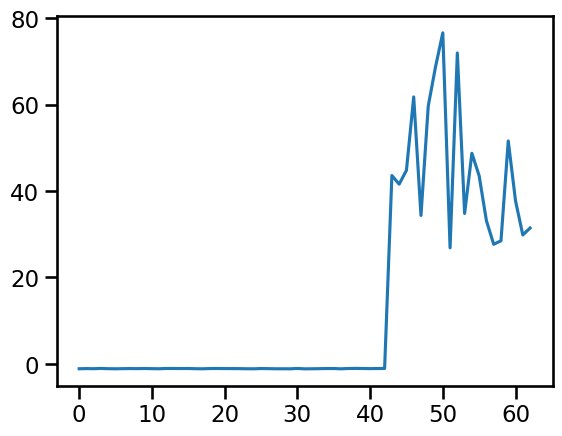

In [21]:
plt.plot(trial_end[:min_trials_len]-move_end[:min_trials_len])

# Occupancy 

## Total Occupancy

(7947,)

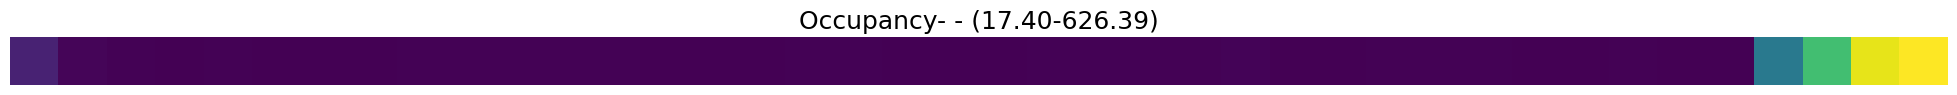

In [22]:
num_bins = 40
min_occ = .1
speed_thresh = 0
max_time = 0.25
occ = compute_occupancy(positions, ptimes, num_bins,min_speed=speed_thresh)
plot_heatmap(occ, title=create_heatmap_title('Occupancy-',occ), figsize=(25, 5))
ptimes.shape

## Extracted trial occupancy 

In [23]:
# Get position data, selecting from movement periods, and recombine across trials
ptimes_trials, positions_trials = select_movement(\
    nwbfile.acquisition['position']['player_position'], move_start, move_end, True)
#ptimes, positions = recombine_trial_data(ptimes_trials, positions_trials)
ptimes_trials.shape

(7947,)

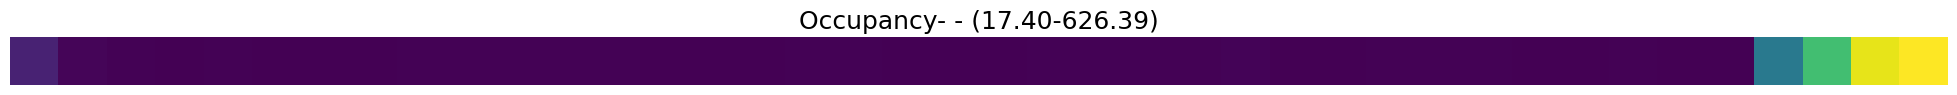

In [24]:
occ = compute_occupancy(positions_trials, ptimes_trials, num_bins,min_speed=speed_thresh)
plot_heatmap(occ, title=create_heatmap_title('Occupancy-',occ), figsize=(25, 5))

# Get the spikes 

In [25]:
# Extract spike data 
spikes = nwbfile.units.get_unit_spike_times(uind)
spikes

array([1.13780001e+00, 1.17490001e+00, 1.18433335e+00, ...,
       2.79194240e+03, 2.79198810e+03, 2.79287237e+03])

In [26]:
unit_name = nwbfile.session_id + '_U' + str(uind).zfill(2)
unit_name

'TRAIN_UT088_session_0_U03'

In [27]:
# Epoch & reset spikes within each move period
spikes_move = epoch_spikes_by_range(spikes, move_start, move_end, reset=True)

move_spikes = []
move_frs = np.zeros(len(spikes_move))
move_spike_pos = []
for ind in range(len(spikes_move)): 
    m_spikes = get_range(spikes, move_start[ind],move_end[ind])
    move_spike_pos.append(get_values_by_times(ptimes, positions, m_spikes))
    move_spikes.append(m_spikes)
    move_frs[ind] = compute_firing_rate(spikes_move[ind],task_range)
    move_spikes_all = np.concatenate(move_spikes).ravel()

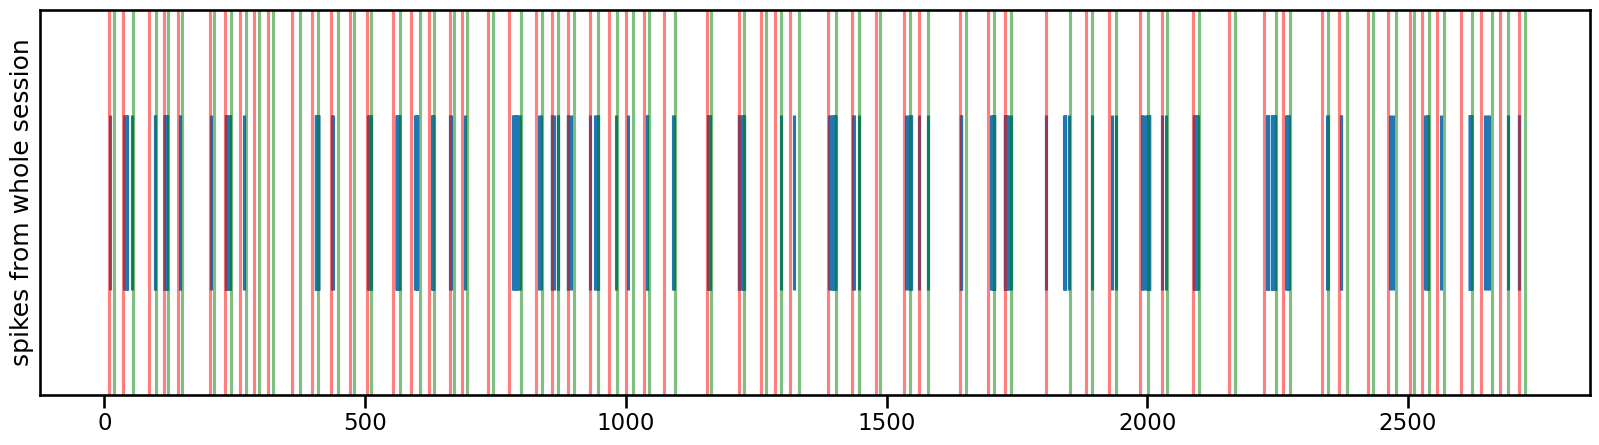

In [28]:
plot_rasters(move_spikes_all, show_axis=True, ylabel='spikes from whole session', yticks=[],
                 figsize = (20,5))

add_vlines(trial_start,  color='red',alpha = .5)   # navigation starts
add_vlines(trial_end,  color='green',alpha = .5) 

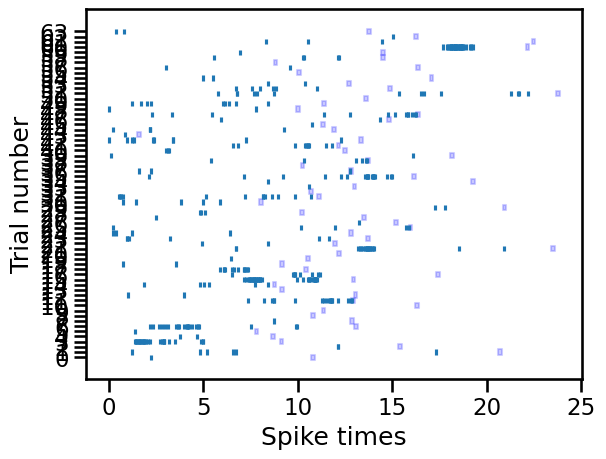

In [29]:
plot_rasters(spikes_move, show_axis=True,  xlabel='Spike times',
                 ylabel="Trial number", yticks=range(0, len(spikes_move)))
add_box_shades(move_end-move_start, np.arange(len(spikes_move)), x_range=0.1, y_range=0.5)

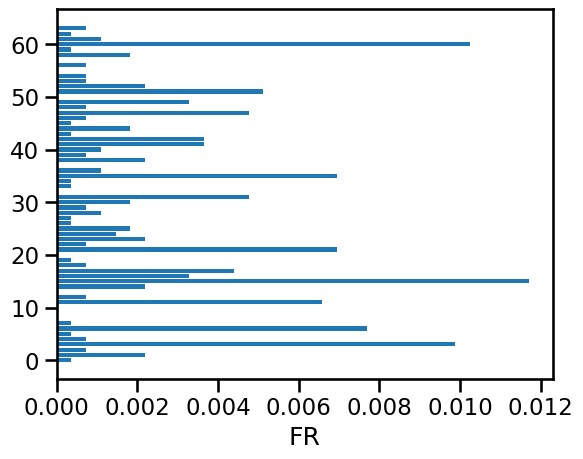

In [30]:
ypos = (np.arange(len(spikes_move))).tolist()
plot_barh(move_frs, ypos,xlabel="FR")

(358,)


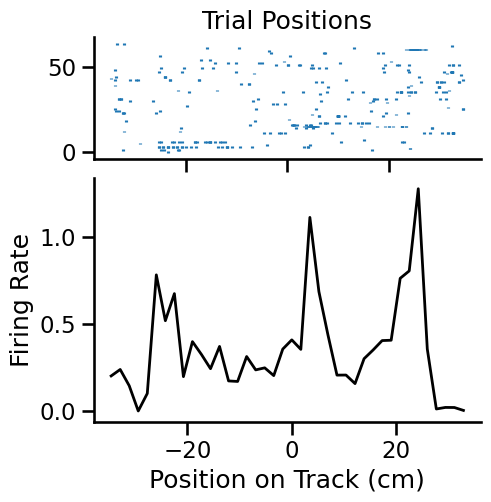

In [31]:
spikes = move_spikes_all
print(spikes.shape)
x_min_track, x_max_track = compute_pos_ranges(positions)

bins = np.linspace(x_min_track, x_max_track, num_bins+1)
spike_pos= get_values_by_times(ptimes, positions, spikes,time_threshold = 0.1)
spike_counts = compute_bin_counts_pos(spike_pos, num_bins)
firing_rates = spike_counts / occ


fig, axs = plt.subplots(2, 1, figsize=(5, 5), gridspec_kw={'height_ratios': [1, 2],})
plt.subplots_adjust(hspace=0.1)  # Adjust the vertical spacing between subplots

plot_rasters(move_spike_pos,ax = axs[0], vline=None, figsize=(10, 5), show_axis=True, title='Trial Positions')
axs[0].spines['top'].set_visible(False)  # Hide the top spine
axs[0].spines['right'].set_visible(False)
# Firing rate map
axs[1].plot( bins[:-1],firing_rates[:], 'k', lw=2)
axs[1].set_xlabel('Position on Track (cm)')
axs[1].set_ylabel('Firing Rate')
axs[1].spines['top'].set_visible(False)  # Hide the top spine
axs[1].spines['right'].set_visible(False)

# Report 

(358,)
Min Track Position:  -34.66216000000001


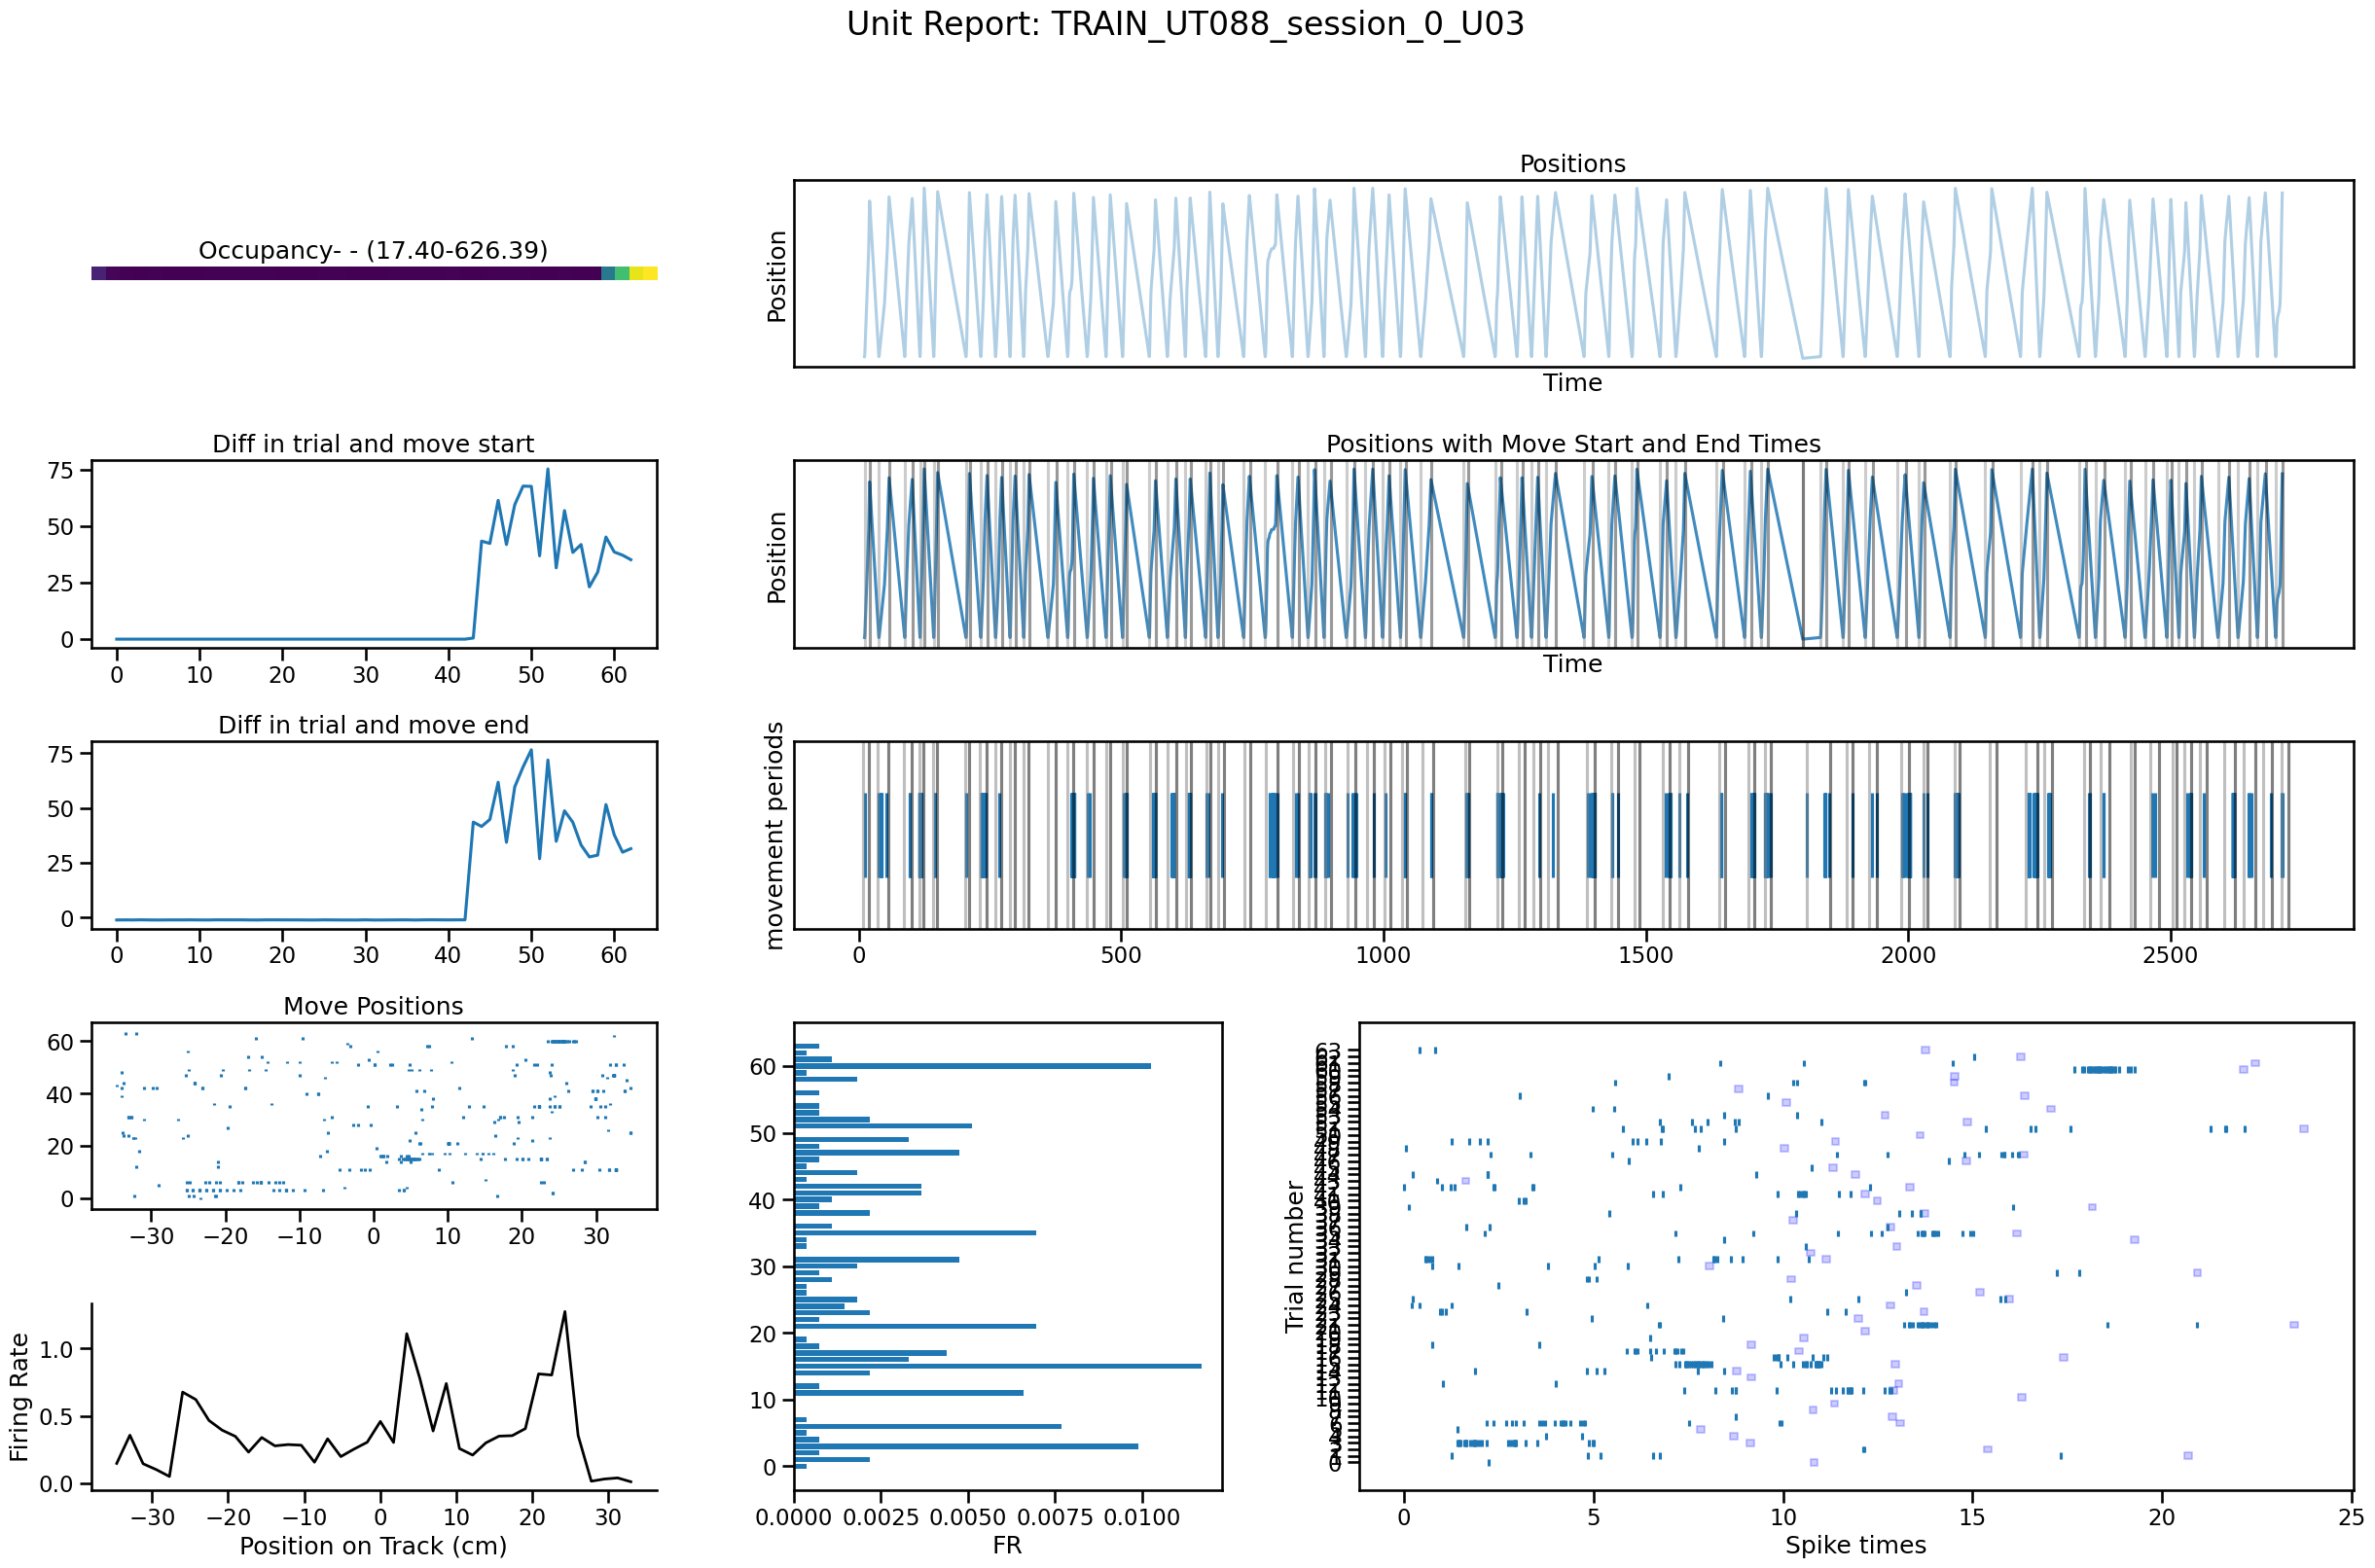

In [32]:
# Initialize figure with grid layout
grid = make_grid(7, 5, wspace=0.4, hspace=0.5, figsize=(30, 25),
                 width_ratios=[0.5, 0.5, 1, 1, 1],
                 title=f'Unit Report: {unit_name}')
plot_heatmap(occ, title=create_heatmap_title('Occupancy-',occ), ax=get_grid_subplot(grid, slice(0,1), slice(0, 2)))
plot_position_by_time(ptimes,positions,ax=get_grid_subplot(grid, slice(0, 1), slice(2, 5)))
plt.title('Positions')

plot_position_by_time(ptimes, positions, alpha=0.85,ax=get_grid_subplot(grid, slice(1,2), slice(2, 5)))
for start in move_start:
    plt.axvline(x=start, color='grey', alpha=0.4)
for end in move_end:
    plt.axvline(x=end, color='black', alpha=0.4)
plt.title('Positions with Move Start and End Times')
plt.xlabel('Time')
plt.ylabel('Position')

# Plot the difference between movement start and trial start 
ax=get_grid_subplot(grid, slice(1,2), slice(0, 2))
ax.plot(trial_start[:min_trials_len]-move_start[:min_trials_len])
ax.set_title('Diff in trial and move start')

ax=get_grid_subplot(grid, slice(2,3), slice(0, 2))
ax.plot(trial_end[:min_trials_len]-move_end[:min_trials_len])
ax.set_title('Diff in trial and move end')

plot_rasters(move_spikes_all, show_axis=True, 
                 ylabel='movement periods', yticks=[],ax=get_grid_subplot(grid, slice(2,3), slice(2, 5)))
add_vlines(trial_start,  color='grey',alpha = .5)   # navigation starts
add_vlines(trial_end,  color='black',alpha = .5)  # navigation stops


bins = np.linspace(x_min_track, x_max_track, num_bins+1)
spike_pos= get_values_by_times(ptimes, positions, spikes)
spike_counts = compute_bin_counts_pos(spike_pos, num_bins)
firing_rates = spike_counts / occ

spikes = move_spikes_all
print(spikes.shape)
x_min_track, x_max_track = compute_pos_ranges(positions)
track_range = [x_min_track, x_max_track]
print('Min Track Position: ', x_min_track)

bins = np.linspace(x_min_track, x_max_track, num_bins+1)
spike_pos= get_values_by_times(ptimes, positions, spikes)
spike_counts = compute_bin_counts_pos(spike_pos, num_bins)
firing_rates = spike_counts / occ

plot_rasters(move_spike_pos,ax=get_grid_subplot(grid, 3, slice(0,2)), vline=None, show_axis=True, title='Move Positions')

ax = get_grid_subplot(grid, 4,slice(0,2))
ax.plot( bins[:-1],firing_rates[:], 'k', lw=2)
ax.set_xlabel('Position on Track (cm)')
ax.set_ylabel('Firing Rate')
ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)


ypos = (np.arange(len(spikes_move))).tolist()
plot_barh(move_frs, ypos,xlabel="FR",ax=get_grid_subplot(grid, slice(3,5),  slice(2,3)))


plot_rasters(spikes_move, show_axis=True,  xlabel='Spike times',
                 ylabel="Trial number", yticks=range(0, len(spikes_move)),ax =get_grid_subplot(grid, slice(3,5),  slice(3,5)) )
add_box_shades(move_end-move_start, np.arange(len(spikes_move)), x_range=0.1, y_range=0.5)

# All Sessions Report 

In [33]:
# items = os.listdir(base_path)
# subj_files = [item for item in items if item != '.DS_Store']
# failed_session = []
# failed_unit = []
# for i,subj in enumerate (subj_files):
#     print('')

#     part_subj = subj.split('_')
#     part_sess = part_subj[-1].split('.')
#     experiment = part_subj[-4]
#     subject = part_subj[-3]
#     session = part_sess[-2]
    
#     print('experiment:',experiment)
#     print('Subject: ',subject)
#     print(f'session_{session}')
    
#     summary = {
#     'experiment' : experiment,
#     'subject' : subject,
#     'session' : session   
# }
    
#     # Get session name
#     session_name = make_session_name(subject,experiment,session)
#     print(session_name)
    
#     # load nwbfile 
#     nwbfile = load_nwbfile(subj,base_path)
#     n_units = len(nwbfile.units)
    
#     # Get num trials
#     n_trials = len(nwbfile.trials)
#     print('Number of trials: {}'.format(n_trials))
#     summary['n_trials'] = str(n_trials)
    
#     # Check task time range 
#     task_range = [nwbfile.trials.start_time[0], nwbfile.trials.stop_time[-1]]
#     task_len = convert_sec_to_min(task_range[1])
#     print('Task length: {:1.2f} minutes'.format(task_len))
#     summary['task_length'] = np.round(task_len,2)
    
#     # Get position data
#     pos = nwbfile.acquisition['position']['player_position']
#     ptimes = pos.timestamps[:]
#     positions = pos.data[:]
    
#     # Get speed data 
#     speed_thresh = .2
#     speed = nwbfile.processing['position_measures']['speed'].data[:]
    
#     # Compute occupancy 
#     occ = compute_occupancy(positions, ptimes, bins = num_bins)
    
#     # Get move  data
#     move_start= nwbfile.trials.movement_start_time[:]
#     move_end= nwbfile.trials.movement_stop_time[:]
    
#     # Get the trial structure based on positions
#     trial_start,trial_end = get_trial_structure(ptimes, positions,mini=-25,maxi = 25, dist = 100)
    
    
#     # Get unit all units
#     for uind in range(n_units):
#         print(' ')
#         print(uind)
#         spikes = nwbfile.units.get_unit_spike_times(uind)
#         print('Original n_spikes: ', spikes.shape)
        
        
#         # get trial spikes 
#         spikes_trial = epoch_spikes_by_range(spikes, trial_start, trial_end, reset=True)

#         trial_spikes = []
#         #trial_frs = np.zeros(len(spikes_trial))
#         trial_spike_pos = []
#         for ind in range(len(spikes_trial)): 
#             t_spikes = get_range(spikes, trial_start[ind],trial_end[ind])
#             trial_spike_pos.append(get_values_by_times(ptimes, positions, t_spikes))
#             trial_spikes.append(t_spikes)
#             #trial_frs[ind] = compute_firing_rate(spikes_trial[ind])
#             trial_spikes_all = np.concatenate(trial_spikes).ravel()
            
        
#         # get move spikes 
#         spikes_move = epoch_spikes_by_range(spikes, move_start, move_end, reset=True)

#         move_spikes = []
#         #move_frs = np.zeros(len(spikes_move))
#         move_spike_pos = []
#         for ind in range(len(spikes_move)): 
#             m_spikes = get_range(spikes, move_start[ind],move_end[ind])
#             move_spike_pos.append(get_values_by_times(ptimes, positions, m_spikes))
#             move_spikes.append(m_spikes)
#             #move_frs[ind] = compute_firing_rate(spikes_move[ind])
#             move_spikes_all = np.concatenate(move_spikes).ravel()
            
#         # Initialize figure with grid layout
#         grid = make_grid(7, 5, wspace=0.4, hspace=0.5, figsize=(40, 25),
#                          width_ratios=[0.5, 0.5, 1, 1, 1],
#                          title=f'Unit Report: {unit_name}')
#         plot_heatmap(occ, title=create_heatmap_title('Occupancy-',occ), ax=get_grid_subplot(grid, slice(0,1), slice(0, 2)))
#         plot_position_by_time(ptimes,positions,ax=get_grid_subplot(grid, slice(0, 1), slice(2, 5)))
#         plt.title('Positions')

#         plot_position_by_time(ptimes, positions, alpha=0.85,ax=get_grid_subplot(grid, slice(1,2), slice(2, 5)))
#         for start in trial_start:
#             plt.axvline(x=start, color='red', alpha=0.4)
#         for end in trial_end:
#             plt.axvline(x=end, color='green', alpha=0.4)
#         plt.title('Positions with Trial Start and End Times')
#         plt.xlabel('Time')
#         plt.ylabel('Position')

#         plot_position_by_time(ptimes, positions, alpha=0.85,ax=get_grid_subplot(grid, slice(2,3), slice(2, 5)))
#         for start in move_start:
#             plt.axvline(x=start, color='grey', alpha=0.4)
#         for end in move_end:
#             plt.axvline(x=end, color='black', alpha=0.4)
#         plt.title('Positions with Move Start and End Times')
#         plt.xlabel('Time')
#         plt.ylabel('Position')

#         # Plot the difference between movement start and trial start 
#         ax=get_grid_subplot(grid, slice(1,2), slice(0, 2))
#         ax.plot(trial_start-move_start)
#         ax.set_title('Diff in trial and move start')

#         ax=get_grid_subplot(grid, slice(2,3), slice(0, 2))
#         ax.plot(trial_end-move_end)
#         ax.set_title('Diff in trial and move end')

#         plot_rasters(trial_spikes_all, show_axis=True, 
#                          ylabel='trial periods', yticks=[],ax=get_grid_subplot(grid, slice(3,4), slice(2, 5)))
#         add_vlines(trial_start,  color='red',alpha = .5)   # navigation starts
#         add_vlines(trial_end,  color='green',alpha = .5)  # navigation stops

#         plot_rasters(move_spikes_all, show_axis=True, 
#                          ylabel='movement periods', yticks=[],ax=get_grid_subplot(grid, slice(4,5), slice(2, 5)))
#         add_vlines(trial_start,  color='grey',alpha = .5)   # navigation starts
#         add_vlines(trial_end,  color='black',alpha = .5)  # navigation stops


#         spikes = trial_spikes_all
#         print(spikes.shape)
#         x_min_track, x_max_track = compute_pos_ranges(positions)
#         track_range = [x_min_track, x_max_track]
#         print('Min Track Position: ', x_min_track)

#         bins = np.linspace(x_min_track, x_max_track, num_bins+1)
#         spike_pos= get_values_by_times(ptimes, positions, spikes)
#         spike_counts = compute_bin_counts_pos(spike_pos, num_bins)
#         firing_rates = spike_counts / occ

#         plot_rasters(trial_spike_pos,ax=get_grid_subplot(grid, 3, 0), vline=None, show_axis=True, title='Trial Positions')

#         ax = get_grid_subplot(grid, 4,0)
#         ax.plot( bins[:-1],firing_rates[:], 'k', lw=2)
#         ax.set_xlabel('Position on Track (cm)')
#         ax.set_ylabel('Firing Rate')
#         ax.spines['top'].set_visible(False)  # Hide the top spine
#         ax.spines['right'].set_visible(False)

#         spikes = move_spikes_all
#         print(spikes.shape)
#         x_min_track, x_max_track = compute_pos_ranges(positions)
#         track_range = [x_min_track, x_max_track]
#         print('Min Track Position: ', x_min_track)

#         bins = np.linspace(x_min_track, x_max_track, num_bins+1)
#         spike_pos= get_values_by_times(ptimes, positions, spikes)
#         spike_counts = compute_bin_counts_pos(spike_pos, num_bins)
#         firing_rates = spike_counts / occ

#         plot_rasters(move_spike_pos,ax=get_grid_subplot(grid, 3, 1), vline=None, show_axis=True, title='Move Positions')

#         ax = get_grid_subplot(grid, 4,1)
#         ax.plot( bins[:-1],firing_rates[:], 'k', lw=2)
#         ax.set_xlabel('Position on Track (cm)')
#         ax.set_ylabel('Firing Rate')
#         ax.spines['top'].set_visible(False)  # Hide the top spine
#         ax.spines['right'].set_visible(False)
        
#         plt.savefig(f'/Users/weijiazhang/Data/Train/report/unit_quality_report/{session_name}_unit_{uind}_report.pdf')
#         plt.close

    
    